In [15]:
###################### Magic commands
##%%timeit -n 1 -r 1
#%%time
#import time
#start = time.time()
###################### at the end
#end = time.time()
#print(end - start)
###################### Packages
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.special
import math 
import numba
from sympy import *
from sympy import symbols
from sympy.plotting import plot3d
from sympy.abc import A,B
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import dblquad
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import lomax
import seaborn as sns
import random
import scipy.stats as st
npr.seed(0)
import warnings
warnings.filterwarnings('ignore')

########## Section 1: Lomax -Clayton Model sampling ########## ########## ########## ########## ########


#################### First example of tail index in GSU2022. Here, Y(t) = cos(2*pi*Z*t) with Z uniform and t\in [0,1]
### We denote z the covariate instead of y.

@numba.njit(parallel=False, fastmath=False) 
def tail_index_theoretical(Z): # Z latent uniform rv on (1/4,1)
    aux = (1/2)*(1+ (np.sin(4*np.pi*Z)/(4*np.pi*Z)))
    out =  (8*aux-3)/2.5
    return out # same shape as Z

@numba.njit(parallel=False, fastmath=False) 
def gamma(z):
    return tail_index_theoretical(z)

@numba.njit(parallel=False, fastmath=False) 
def theta(z):
    return 1/tail_index_theoretical(z)

######################### Generating uniforms with survival Clayton copula with parameter \theta_C = \gamma(z)
                       
@numba.njit(parallel=True, fastmath=False) 
def HRT_inverse(u,x,theta_C):
    return 1 - (((1 - u)**theta_C*(u*x - u - x + 1))**(theta_C/(theta_C + 1))*(1 - u)**theta_C/(((1 - u)**theta_C*(u*x - u - x + 1))**(theta_C/(theta_C + 1))*((1 - u)**theta_C - 1) + (1 - u)**theta_C))**(1/theta_C)

@numba.njit(parallel=True, fastmath=False) 
def HRT_copula_bivariate(U,theta_C): # U=npr.uniform(0,1,size=(N,n,2)) ; theta_C = gamma(z)
    N=U.shape[0]
    n=U.shape[1]
    out=np.zeros((N,n,2))
    out[:,:,0]=U[:,:,0]
    for k in numba.prange(N):
        for i in numba.prange(n):
            out[k,i,1] = HRT_inverse(out[k,i,0],U[k,i,1],theta_C)
    return out

############## Generating Lomax-survivalClayton with copula parameter \theta_C = \gamma(z) and Pareto(gamma(z),a_j)-parameters
############ where \gamma(z) and a_j=1.25*j for 1\le j \le d.

@numba.njit(parallel=False, fastmath=False)
def Lomax_quantile_function(x,theta,s): 
    return s*((1-x)**(-1/theta)-1)

# Pareto type II with location mu=0, that is Lomax, with sigma = a_j = 1.25*(1+j)
@numba.njit(parallel=True, fastmath=False)
def Lomax_iterated_sample(data0,t): # data0 is uniform data sample with copula survival Clayton, shape (N,n,d)
    N=data0.shape[0]
    n=data0.shape[1]
    d=data0.shape[2]
    out = np.zeros((N,n,d))
    #S = np.zeros((d)) # Matrix of scale Pareto parameters
    #for i in numba.prange(d):
        #S[i] = 1.25*(2+i) # a_j=1.25*(1+j) for 1\le j \le d in the pdf. 
        # We add +1 more (so we have 2) because of the indices shift in python
    for k in numba.prange(N):
        for i in numba.prange(n):
            for j in numba.prange(d):
                out[k,i,j] = Lomax_quantile_function(data0[k,i,j],t,1.25*(2+j)) # resp. S[i]
    return out ### shape = (N,n,d)

def Lomax_survival_Clayton_compound(N,n,d,t,style=True):  # t=theta(z) 
    # style = False is what it should be; style = True is Khalil Said PhD style (page 82)
    G = np.random.gamma(t, 1, size=(N,n)) 
    data = np.zeros((N,n,d))
    for j in range(d):
        if style:
            intensity=G[:,:]/((1.25)*(2+j))
        else:
            intensity=G[:,:]*((1.25)*(2+j)) 
        data[:,:,j] =npr.exponential(1/intensity)  #scipy.stats.expon.rvs(loc=0,scale=1/intensity)
    return data

@numba.njit(parallel=True, fastmath=False)
def survival_Clayton_from_compound(data,t): #data=Lomax_survival_Clayton_compound(N,n,d,z) 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]  
    data0 = np.zeros((N,n,d))
    for j in range(d):
        data0[:,:,j]= 1-(1+1.25*(2+j)*data[:,:,j])**(-t) 
    return data0
    
######################################################################### ]

###################################################################### Weighted Empirical CFD/Quantiles/Copula


################################################### [Kernels and weights

@numba.njit(parallel=False, fastmath=False) 
def Gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*np.power(x,2))

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel(x): # x is a np.array of shape (p,q);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        for j in numba.prange(x.shape[1]):
            if np.abs(x[i,j])<=1:
                out[i,j] = np.multiply(3/4,1-np.power(x[i,j],2))
            else:
                out[i,j]=0
    return out

@numba.njit(parallel=True, fastmath=False) 
def Triangular_kernel(x): # x is a np.array of shape (p,q);     
    out = np.zeros_like(x)
    for i in numba.prange(x.shape[0]):
        for j in numba.prange(x.shape[1]):
            if x[i,j]<=1 and x[i,j] >=0:
                out[i,j] = 1.9-1.8*x[i,j]
            else:
                out[i,j]=0
    return out

@numba.njit(parallel=True, fastmath=False)
def L2_cardinal(h,z,Z): # Z=npr.uniform(1/4,1,size=(N,n)), z in [1/4,1]
    N=Z.shape[0]
    n=Z.shape[1]
    grid_cov=np.linspace(0,1,100)
    m=grid_cov.shape[0]
    M=np.zeros((1,))
    M[0]=m # m is not anymore a "int" but a "np.float64"
    out = np.zeros((N,n))
    A = np.zeros((N,n,m))
    for p in numba.prange(m):
        A[:,:,p]=(np.cos(2*np.pi*Z[:,:]*grid_cov[p])-np.cos(2*np.pi*z*grid_cov[p]))**2
    norm = np.sqrt((1/(M[0]+1))*np.sum(A,axis=2))
    # discrete L^2-norm of (Y_i-y) with y(t)=cos(2*pi*z*t) and Y_i observed thru Z_i
    indicator = np.where(norm<=h,1,0)
    return np.sum(indicator,axis=1) ### shape = (N,)

@numba.njit(parallel=True, fastmath=False)
def belongs(val,vec):
    res = False
    if np.where(vec == val)[0].shape[0] > 0:
        res = True
    return res

@numba.njit(parallel=True, fastmath=False)
def adaptative_window(m,z,Z,eps,h): # Z=npr.uniform(1/4,1,size=(N,n)), z in [1/4,1]
    # eps = error threshold for c=n*h
    N=Z.shape[0]
    n=Z.shape[1]
    c=n*h
    hgrid=np.linspace(0,1,m)
    card_on_grid=np.zeros((N,m))
    out=np.zeros((N,))
    for p in numba.prange(m):
        card_on_grid[:,p]= L2_cardinal(hgrid[p],z,Z)
    aux= np.where(card_on_grid-c<1+np.floor(eps),1,0)
    aux2= np.where(-np.floor(eps)-1<card_on_grid-c,1,0)
    aux3= np.multiply(aux,aux2)
    for k in range(N):
        if belongs(1,aux3[k,:]):
            p_star = np.flatnonzero(aux3[k,:] == 1)[0]
            out[k] = hgrid[p_star]
    moy=np.mean(out[out!=0])
    out[out==0] = moy   
    return out

@numba.njit(parallel=True, fastmath=False) 
def adaptative_Nadaraya_weight(h_vect,z,Z,kernel_style): # Z=npr.uniform(1/4,1,size=(N,n)), z in [1/4,1]
    # h_vect.shape = (N,)
    N=Z.shape[0]
    n=Z.shape[1]
    grid_cov=np.linspace(0,1,100)
    A = np.zeros((N,n,100))
    for p in numba.prange(100):
        A[:,:,p]=(np.cos(2*np.pi*Z[:,:]*grid_cov[p])-np.cos(2*np.pi*z*grid_cov[p]))**2
    norm = np.sqrt((1/(100.0+1))*np.sum(A,axis=2))
    # discrete L^2-norm of (Y_i-y) with y(t)=cos(2*pi*z*t) and Y_i observed thru Z_i
    if kernel_style == 'Triangular':
        out_Triangular=np.zeros((N,n))
        K_Triangular=Triangular_kernel(np.divide(norm,h_vect.reshape(-1,1)))
        for k in numba.prange(N):
            out_Triangular[k,:]=K_Triangular[k,:]/np.sum(K_Triangular[k,:])
        return out_Triangular
    elif kernel_style == 'Gaussian':
        out_Gaussian=np.zeros((N,n))
        K_Gaussian=Gaussian_kernel(np.divide(norm,h_vect.reshape(-1,1)))
        for k in numba.prange(N):
            out_Gaussian[k,:]=K_Gaussian[k,:]/np.sum(K_Gaussian[k,:]) 
        return out_Gaussian
    elif kernel_style == 'Epanechnikov':
        out_Epanechnikov = np.zeros((N,n))
        K_Epanechnikov=Epanechnikov_kernel(np.divide(norm,h_vect.reshape(-1,1)))
        for k in numba.prange(N):
            out_Epanechnikov[k,:]=K_Epanechnikov[k,:]/np.sum(K_Epanechnikov[k,:])
        return out_Epanechnikov
    return ### shape = (N,n)

################################################### ][ Tail index and ratio estimators

@numba.njit(parallel=True, fastmath=False)   
def weighted_quantile(data,weight,alpha):  # data.shape=weight.shape=(n) or (n,) # treshold in (0,1)
    sorter = np.argsort(data)
    data = data[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(alpha, weighted_quantiles, data)

@numba.njit(parallel=True, fastmath=False) 
def iterated_weq(data,weight,alpha): # same treshold for all marginals and iterations 
    # data.shape = (N,n,d); weight.shape=(N,n)
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out = np.zeros((N,d))
    for k in numba.prange(N):
        for j in numba.prange(d):
            out[k,j]=weighted_quantile(data[k,:,j],weight[k,:],alpha)
    return out # shape = (N,d)

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator(data,weight,alpha,J): 
    N=data.shape[0]
    d=data.shape[2]
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=iterated_weq(data,weight,alpha) # quantile_data2.shape=(N,d)
    out=np.zeros((N,))
    aux=np.zeros((N,J))
    for k in numba.prange(N):
        for j in numba.prange(J):
            quantile_data1=iterated_weq(data,weight,1-subdivision[j]*(1-alpha))
            aux[k,j] = np.log(quantile_data1[k,0])-np.log(quantile_data2[k,0])
            aux[k,j] /= -np.sum(np.log(subdivision))
        out[k] = np.sum(aux[k,:])
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_equiv_constants_theoretical(z,d):
    t=np.int32(d)
    out = np.zeros((t,))
    out[0]=1
    for j in numba.prange(t):
        out[j] = (1.25*(2+j)/2.5)**theta(z)
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_equiv_constants_estimator(data,weight,alpha,J,intermediate_seq,bias): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    l = np.floor(n**intermediate_seq)
    quantile_data=iterated_weq(data,weight,1-(l+1)/n)
    if bias == False:
        gamma_data=tail_index_gamma_estimator(data,weight,alpha,J) # shape = (N,)
    else:
        gamma_data=tail_index_gamma_unbiased_estimator(data,weight,alpha,J) # shape = (N,)    quantile_data=iterated_weq(data,weight,1-(l+1)/n)
    out=np.zeros((N,d))
    for k in numba.prange(N):
        for j in numba.prange(d):
            out[k,j]=(quantile_data[k,j]/quantile_data[k,0])**(1/gamma_data[k])
    return out 

@numba.njit(parallel=True, fastmath=False) 
def tail_equiv_constants_ratio(data,weight,alpha,J,z,intermediate_seq,bias): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    l = np.floor(n**intermediate_seq)
    if bias == False:
        gamma_data=tail_index_gamma_estimator(data,weight,alpha,J) # shape = (N,)
    else:
        gamma_data=tail_index_gamma_unbiased_estimator(data,weight,alpha,J) # shape = (N,)
    quantile_data=iterated_weq(data,weight,1-(l+1)/n)
    out=np.zeros((N,d))
    T=tail_equiv_constants_theoretical(z,d)
    for k in numba.prange(N):
        for j in numba.prange(d):
            out[k,j]=(quantile_data[k,j]/quantile_data[k,0])**(1/gamma_data[k])
    return np.divide(out,T) 

################################################### ][ Copula 

@numba.njit(parallel=True, fastmath=False) 
def marginal_wecdf(data,weight,x): # x row vector of length d (each marginal has its own treshold)
    # e.g. for uniform treshold t, x=t*np.ones((d,))
    # data.shape = (N,n,d); weight.shape=(N,n)
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,d))
    for k in numba.prange(N):
        for j in numba.prange(d):
            indicator_matrix = np.where(data[:,:,j]<x[j],1,0) # binary matrix with same shape as data representating the indicator matrix 1_{X_ij<x_j}
            out[k,j]= np.sum(np.multiply(indicator_matrix[k,:],weight[k,:]))
    return out/n # (N,d)

@numba.njit(parallel=True, fastmath=False)
def rank(U): # U.shape = (N,n,d)
    R = np.empty_like(U)
    for p in numba.prange(U.shape[0]):
        for j in numba.prange(U.shape[2]):
            R[p,:, j] = np.argsort(np.argsort(U[p,:, j]))+1
    return R

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_data(R,weight): # ie: \hat{F}_{j,n,y}(X_ij); R = rank(data) with shape (N,n,d); weight.shape=(N,n)
    N=R.shape[0]
    n=R.shape[1]
    d=R.shape[2]
    out=np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            for j in numba.prange(d):
                r=np.int32(R[k,i,j])
                out[k,i,j]=np.sum(weight[k,0:r])
    return out/n 

@numba.njit(parallel=True, fastmath=False) 
def bivariate_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,1,0)
    B=np.where(data[:,:,k]<y,1,0)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_anti_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,0,1)
    B=np.where(data[:,:,k]<y,0,1)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_ecdf(data,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum((biv_indicator),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_survival_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_anti_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def empirical_uniform_data(data,weight): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out = np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            out[k,i,:]=marginal_wecdf(data,weight,data[k,i,:])[k,:]
    return out

@numba.njit(parallel=True, fastmath=False) 
def weighted_empirical_copula(data,weight,j_1,j_2,u,v): # u.shape = (2,) in (0,1)
        # data.shape = (N,n,d); weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,n))
    data=empirical_uniform_data(data,weight)
    biv_indicator=bivariate_indicator(emp_unif_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_empirical_copula(weighted_ranked_data,weight,j_1,j_2,u,v): # u,v in (0,1)
        # weighted_ranked_data=weighted_ranked_data(R.astype(int),weight) where R=rank(data); 
        # weighted_ranked_data.shape = (N,n,d) is ; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=weighted_ranked_data.shape[0]
    n=weighted_ranked_data.shape[1]
    d=weighted_ranked_data.shape[2]
    out=np.zeros((N,n))
    biv_indicator=bivariate_indicator(weighted_ranked_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape

@numba.njit(parallel=True, fastmath=False) 
def bivariate_westdf(data,weight,j_1,j_2,x,y,intermediate_seq): # classic copula stdf version
    # data.shape = (N,n,d) -> Pareto-Clayton; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    # intermediate_seq is a real number in (0,1), eg k_n = n^1/2
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    t=np.power(n,intermediate_seq-1)
    u=np.array([1-t*x,1-t*y])
    c=weighted_empirical_copula(data,weight,j_1,j_2,u)  
    return x+y -(1-c)/t # shape = (N)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_wrestdf(data,weight,j_1,j_2,x,y,intermediate_seq): # ranked stdf version
    # data.shape = (N,n,d) or even data0 Pseudo unif Clayton; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    # intermediate_seq is a real number in (0,1), eg k_n = n^1/2
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    t=np.power(n,intermediate_seq-1)
    w = weighted_ranked_data(rank(data),weight) 
    c = weighted_ranked_empirical_copula(w,weight,j_1,j_2,1-t*x,1-t*y)
    return x+y -(1-c)/t # shape = (N)

################################################### ] [ Plotting the tail index estimation

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_unbiased_estimator(data,weight,alpha,J): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,))
    t=tail_index_gamma_estimator(data,weight,alpha,J)
    x1 = np.power(-1+1/t,-t) # shape = (N,)
    x2 = iterated_weq(data,weight,alpha)[:,0] # shape = (N,)
    x = np.multiply(x1,x2) # shape = (N,)
    for k in numba.prange(N):
        out[k] = bivariate_survival_wecdf(data,weight,0,0,x[k],x[k])[k]
        out[k] = (1-alpha)/(1-alpha+out[k])
    return out

@numba.njit(parallel=True, fastmath=False)  
def plot_tail_index_adaptative_window(Z,U,J,eps,alpha,model,kernel_style,bias):
    # bias = False is normal version of GSU2022 (hat version),
    # bias = True is the "unbiaised" estimator of GSU2022 (tilde version)
    # U=npr.uniform(0,1,size=(N,n,d,m)) with d=1 
    # Z=npr.uniform(1/4,1,size=(N,n,m)) with m the discretization parameter -> Weight
    # kernel_style is 'Epanechnikov', 'Gaussian' or 'Triangular' GSU2022
    N=Z.shape[0]
    n=Z.shape[1]
    m=Z.shape[2]
    zgrid=np.linspace(1/4,1,m)
    out=np.zeros((N,m))
    for k in numba.prange(m):
        if n==2000:
            c=280
            h_star=adaptative_window(m,zgrid[k],Z[:,:,k],eps,h)
        else:
            c=100
            h_star=adaptative_window(m,zgrid[k],Z[:,:,k],eps,h)
        weight = adaptative_Nadaraya_weight(h_star,zgrid[k],Z[:,:,k],kernel_style)
        data2=np.power(1-U[:,:,:,k],-gamma(zgrid[k]))
        if bias == False: 
            out[:,k]=tail_index_gamma_estimator(data2,weight,alpha,J)
        else:
            out[:,k]=tail_index_gamma_unbiased_estimator(data2,weight,alpha,J)
    return out

################################################### ] [ Plotting the stdf estimation 

@numba.njit(parallel=True, fastmath=False) 
def plot_westdf(data,weight,m,h,intermediate_seq,j_1,j_2,domain,copula_style): 
    # data.shape = (N,n,d) -> Pareto-Clayton; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    # intermediate_seq is a real number in (0,1), eg k_n = n^1/2    N=data.shape[0]
    # copula_style = 'ranked' -> Weighted Ranked Empirical Copula versus 'classic'
    n=data.shape[1]
    d=data.shape[2]
    xgrid=np.linspace(0,domain,m)
    out_classic=np.zeros((m))
    out_ranked=np.zeros((m))
    if copula_style == 'classic':
        for p in numba.prange(m):
            out_classic[p]= np.mean(bivariate_westdf(data,weight,j_1,j_2,xgrid[p],1,intermediate_seq))
        return out_classic
    elif copula_style == 'ranked':
        for p in numba.prange(m):
            out_ranked[p]= np.mean(bivariate_wrestdf(data,weight,j_1,j_2,xgrid[p],1,intermediate_seq))
        return out_ranked
    return 



In [ ]:
%%time

N=500
n=2000
d=2
z=0.4
#t=0.04 
t=theta(z)

data00=HRT_copula_bivariate(npr.uniform(0,1,size=(N,n,2)),1/t)
data01=Lomax_iterated_sample(data00,t)

data11=Lomax_survival_Clayton_compound(N,n,d,t,False)
data10=survival_Clayton_from_compound(data11,t)

data21=Lomax_survival_Clayton_compound(N,n,d,t,True)
data20=survival_Clayton_from_compound(data21,t)

#fig = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(2, 3,figsize=(20, 10),sharex=True, sharey=False) #sharex='col', sharey='row') sharex=True, sharey=False)
#fig.subplots_adjust(hspace=0.2, wspace=1)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)



ax1.scatter(data00[0,:, 0],data00[0,:, 1], cmap='hot')
ax2.scatter(data10[0,:, 0],data10[0,:, 1], cmap='hot')
ax3.scatter(data20[0,:, 0],data20[0,:, 1], cmap='hot')
ax4.scatter(data01[0,:, 0],data01[0,:, 1], cmap='hot')
ax5.scatter(data11[0,:, 0],data11[0,:, 1], cmap='hot')
ax6.scatter(data21[0,:, 0],data21[0,:, 1], cmap='hot')


ax1.set_title('HRT Copula')
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)

ax2.set_title('SurvClayton_compound')
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)

ax3.set_title('SurvClayton_compound_Said')
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)
ax4.set_title('Lomax_HRT')
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax5.set_title('Lomax_SurvClayton_compound')
ax5.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax6.set_title('Lomax_SurvClayton_compound_Said')
ax6.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.show()
print(t)

In [ ]:
%%time
################################################### Tail index plot
N=500
d=1
m=50  
J=9
intermediate_seq=1/2
eps=10         
for kernel_style in ['Gaussian','Triangular']:
    for bias in [False,True]:
        for n in [500,2000]:
            if n == 500:
                alpha=0.84
            else:
                alpha=0.805
            Z=npr.uniform(1/4,1,size=(N,n,m))
            U=npr.uniform(0,1,size=(N,n,d,m))  
            out = plot_tail_index_adaptative_window(Z,U,P,L,C,J,eps,alpha,intermediate_seq,kernel_style,bias)
            pd.DataFrame(out).to_csv("tail_index_adaptative{}.csv".format((N,n,m,J,eps,alpha,intermediate_seq,kernel_style,bias)), header=False, index=False)


In [ ]:
%%time
for n,alpha,h in [(1000,0.825,0.18)]:#,(1500,0.815,0.16),(2000,0.805,0.14)]:
    copula_style = 'ranked'
    kernel_style = 'Gaussian'
    bias = False
    N=500
    d=4
    z=0.5
    J=9
    c = n*h
    eps=10
    m=50
    intermediate_seq=1/2
    Z=npr.uniform(1/4,1,size=(N,n))
    h_star=adaptative_window(m,z,Z,eps,h)
    data=Lomax_survival_Clayton_compound(N,n,d,t,style=False)   
    weight=adaptative_Nadaraya_weight(h_star,z,Z,kernel_style)
    T=tail_equiv_constants_ratio(data,weight,alpha,J,z,intermediate_seq,bias)
    pd.DataFrame(T).to_csv("tail_equiv_constants_ratio_adaptive{}.csv".format((N,n,d,J,z,h,alpha,intermediate_seq,kernel_style,bias)), header=False, index=False)

In [ ]:
################ Symbolic calculus, inversion of the HRT Copula first derivative for sampling
import sympy as sym
x,y,c = sym.symbols('x,y,c')
eq1 = sym.Eq(1/(2-1)-x, -(1/(2-1))*(1/c)*(y+c**(1/2))**(1-2)+x*y)
eq2 = sym.Eq(1/(2-1)-x*(y**2)/c, -(1/(2-1))*(1/c)*(1/y+c**(-1/2))**(1-2)+(x*y**(2-1))/c)
result = sym.solve([eq1,eq2],(x,y))
print(result)
########################################################################################
x,y,T,c = sym.symbols('x,y,T,c')
eq1 = sym.Eq(1/(T-1)-x, -(1/(T-1))*(1/c)*(y+c**(1/T))**(1-T)+x*y)
eq2 = sym.Eq(1/(T-1)-x*(y**T)/c, -(1/(T-1))*(1/c)*(1/y+c**(-1/T))**(1-T)+(x*y**(T-1))/c)
result = sym.solve([eq1,eq2],(x,y))
print(result)
########################################################################################
from sympy import symbols, exp, solve, Eq
x, u, v, a = symbols('x u v a')
expr1 =1-(((1-u)**(-a)+(1-v)**(-a)-1)**(-1-1/a))*(1-u)**(-1-a)
res = solve(Eq(x, expr1), v)
res

In [1127]:
# bfgs algorithm local optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand
import scipy.integrate as integrate
import scipy.special as special
import numpy as np
import matplotlib.pyplot as plt

def vfi11(x): # x = (eta,beta_2) ; \vfi^{(1)}_{k,y} with k=1
    #x=np.float64(x)
    c = tail_equiv_constants_theoretical(z,2)
    return gamma(z)/(gamma(z)-1) -x[0]*(1+x[1]) 

def vfi12(x): # x = (eta,beta_2) ; \vfi^{(2)}_{k,y} with k=1
    #x=np.float64(x)
    c = tail_equiv_constants_theoretical(z,2)
    integral0 = integrate.quad(lambda t: stdf_theoretical((t**(-theta(z)))*c[1],1,z), x[1], np.inf)
    return integral0[0]

def vfi1(x): # x = (eta,beta_2) ; \vfi_{k,y} with k=1
    #x=np.float64(x)
    return vfi11(x)+vfi12(x)

def vfi21(x):  # x = (eta,beta_2) ; \vfi^{(1)}_{k,y} with k=2
    #x=np.float64(x)
    c = tail_equiv_constants_theoretical(z,2)
    return gamma(z)/(gamma(z)-1) - (x[0]*(x[1]**(theta(z)))/c[1])*(1+1/x[1])

def vfi22(x): # x = (eta,beta_2) ; \vfi^{(2)}_{k,y} with k=2
    #x=np.float64(x)
    c = tail_equiv_constants_theoretical(z,2)
    integral1 = integrate.quad(lambda t: stdf_theoretical((t**(-theta(z)))/c[1],1,z), 1/x[1], np.inf)
    return integral1[0]

def vfi2(x):  # x = (eta,beta_2) ; \vfi_{k,y} with k=2
    #x=np.float64(x)
    return vfi21(x)+vfi22(x)

def loss(x):
    #x=np.float64(x)
    return (1/2)*(vfi1(x)**2+vfi2(x)**2)

def delta1_vfi1(x):
    return -1-x[1]

def delta1_vfi2(x):
    c = tail_equiv_constants_theoretical(z,2)
    return -(2*x[1]**(theta(z)))/c[1]

def delta2_vfi1(x):
    c = tail_equiv_constants_theoretical(z,2)
    return -x[0]-stdf_theoretical(c[1]*x[1]**(-theta(z)),1,z)

def delta2_vfi2(x):
    c = tail_equiv_constants_theoretical(z,2)
    return -(x[0]*x[1]**(theta(z)-1))/(gamma(z)*c[1]) - ((theta(z)-1)*x[1]**(theta(z)-2))/c[1] + stdf_theoretical((x[1]**(theta(z)))/c[1] ,1,z)/(x[1]**2)

def delta2_loss(x):
    return np.multiply(vfi1(x),delta2_vfi1(x))+np.multiply(vfi2(x),delta2_vfi2(x))

def delta1_loss(x):
    return np.multiply(vfi1(x),delta1_vfi1(x))+np.multiply(vfi2(x),delta1_vfi2(x))

def delta_loss(x):
    return [delta1_loss_bis(x),delta2_loss_bis(x)]

z=1/4+1/2

# define range for input
r_min, r_max = 0, 1
# define the starting point as a random sample from the domain
pt = r_min + npr.uniform(0,1,size=(2,)) * (r_max - r_min)
# perform the l-bfgs-b algorithm search
myfactr = 1e7
result = minimize(loss, pt, method='L-BFGS-B',bounds=[(r_min,r_max)]*2,jac=delta_loss,options={'ftol' : myfactr * np.finfo(float).eps}) 
# summarize the result
print('Success : %s' % result['success'])
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
print('Number of iterations performed by the optimizer : %s' % result['nit'])
# evaluate solution
solution = result['x']
evaluation = loss(solution)
print('Solution: loss(%s) = %.5f' % (solution, evaluation))


Success : True
Status : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Total Evaluations: 21
Number of iterations performed by the optimizer : 2
Solution: f([4.12483867e-17 3.74001035e-01]) = 0.19781


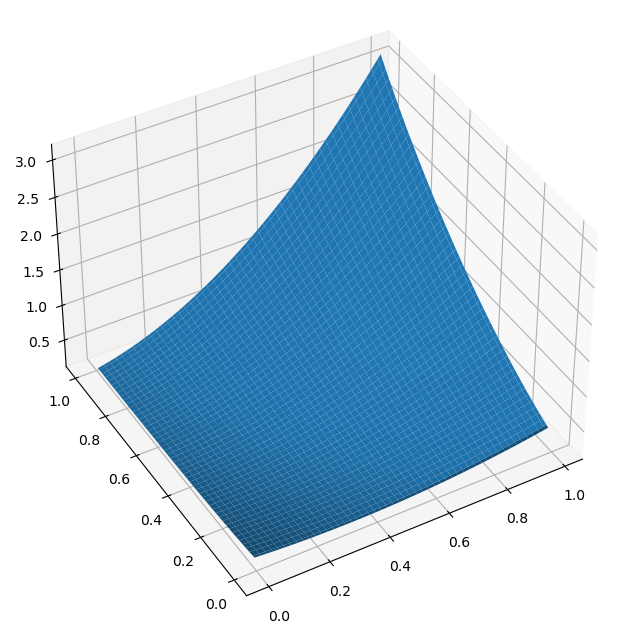

In [1237]:

z=1/4+1/2
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100,100))
for k in range(100):
    for j in range(100):
        x=np.array([X[k,j],Y[k,j]])
        Z[k,j] = loss(x)
        
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(40, 600)
plt.show()

In [ ]:
%%time

import scipy.integrate as integrate
import scipy.special as special

def bivariate_loss_function_approx(x,Data,weight,intermediate_seq,bias):
    N=Data.shape[0]
    n=Data.shape[1]
    d=Data.shape[2]
    Gamma=tail_index_gamma_unbiased_estimator(Data,weight,alpha,J)
    c=tail_equiv_constants_estimator(Data,weight,alpha,J,intermediate_seq,bias)
    aux=np.zeros((N,2))
    out=np.zeros((N,))
    for k in range(N):
        j_2=1
        integral0 = integrate.quad(lambda t: hat_L(Data,weight,0,1,t**(-1/Gamma[k])*c[k,1],1.0,intermediate_seq)[k], x[1], np.inf)
        integral1 = integrate.quad(lambda t: hat_L(Data,weight,0,1,t**(-1/Gamma[k])/c[k,1],1.0,intermediate_seq)[k], 1/x[1], np.inf)
        aux[k,0]= Gamma[k]/(Gamma[k]-1)-(c[k,1]*x[0]*x[1]**(1/Gamma[k]))*(1+x[1])+integral0[0]
        aux[k,1]=Gamma[k]/(Gamma[k]-1)-((x[0]*x[1]**(1/Gamma[k]))/c[k,1])*(1+1/x[1])+integral1[0]
        out[k]=(1/2)*(aux[k,0]**2+aux[k,1]**2)
    return 

N=50 # iterations
n=50
d=2
m=10 # grid length
alpha=0.9 
l=2
z=0.5 
h=0.84 
J=9 
eps=10
domain = 1
j_1=0
j_2=1
t=1/gamma(z)
intermediate_seq=1/2
copula_style = 'ranked'
kernel_style = 'Gaussian'
bias = False

Z=npr.uniform(1/4,1,size=(N,n))
h_star=adaptative_window(m,z,Z,eps,h)
weight=adaptative_Nadaraya_weight(h_star,z,Z,kernel_style) 
data=Lomax_survival_Clayton_compound(N,n,d,t,style=False)
#R= rank(data)
#w=weighted_ranked_data(R,weight)
U=npr.uniform(0,1,size=(N,n,2))
#x=npr.uniform(0,1,size=(2,))
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = np.zeros((100,100))
for k in range(100):
    for j in range(100):
        x=np.array([X[k,j],Y[k,j]])
        Z[k,j] = bivariate_loss_function_approx(x,data,weight,intermediate_seq,bias)
        
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(40, 600)
plt.show()


In [24]:
%%time
################################################### Stable tail dependence function :(
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

N=50 # iterations
n=50
d=2
m=10 # grid length
alpha=0.9 
l=2
z=0.5 
h=0.84 
J=9 
eps=10
domain = 1
j_1=0
j_2=1
t=1/gamma(z)
intermediate_seq=1/2
copula_style = 'ranked'
kernel_style = 'Gaussian'
bias = False

Z=npr.uniform(1/4,1,size=(N,n))
h_star=adaptative_window(m,z,Z,eps,h)
weight=adaptative_Nadaraya_weight(h_star,z,Z,kernel_style) 
data=Lomax_survival_Clayton_compound(N,n,d,t,style=False)
#R= rank(data)
#w=weighted_ranked_data(R,weight)
#out=plot_westdf(data,weight,m,h,intermediate_seq,j_1,j_2,domain,copula_style)
T1=tail_equiv_constants_estimator(data,weight,alpha,J,intermediate_seq,bias)
T2=tail_equiv_constants_theoretical(z,d)
T1,T2
#plt.plot(out, 'b') 
#plt.plot(stdf_theoretical(np.linspace(0,1,m),1,z),'p')

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mNameError: name 'tail_index_gamma_unbiaised_estimator' is not defined[0m

In [ ]:
%%time
################################################### Tail equivalence constants

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

N=500
m=50
d=4
z=0.5
J=9
eps=10
model = 3
kernel = 1
intermediate_seq=1/2
t=theta(z)
copula_style = 'ranked'
kernel_style = 'Gaussian'
bias = False


n1=500
n2=1000
n3=1500
n4=2000

alpha1=0.84
alpha2=0.825
alpha3=0.815
alpha4=0.805

h1=0.2
h2=0.18
h3=0.16
h4=0.14

Z1=npr.uniform(1/4,1,size=(N,n1))
Z2=npr.uniform(1/4,1,size=(N,n2))
Z3=npr.uniform(1/4,1,size=(N,n3))
Z4=npr.uniform(1/4,1,size=(N,n4))

#np.savetxt("Z1{}.csv".format((N,n1)), Z1)
#np.savetxt("Z2{}.csv".format((N,n2)), Z2)
#np.savetxt("Z3{}.csv".format((N,n3)), Z3)
#np.savetxt("Z4{}.csv".format((N,n4)), Z4)

#Z1 = np.loadtxt("Z1{}.csv".format((N,n1)))
#Z2 = np.loadtxt("Z2{}.csv".format((N,n2)))
#Z3 = np.loadtxt("Z3{}.csv".format((N,n3)))
#Z4 = np.loadtxt("Z4{}.csv".format((N,n4)))

data10=Lomax_survival_Clayton_compound(N,n1,d,t,False)
data20=Lomax_survival_Clayton_compound(N,n2,d,t,False)
data30=Lomax_survival_Clayton_compound(N,n3,d,t,False)
data40=Lomax_survival_Clayton_compound(N,n4,d,t,False)

#h1_star=adaptative_window(m,z,Z1,eps,h1)
#h2_star=adaptative_window(m,z,Z2,eps,h2)
##h3_star=adaptative_window(m,z,Z3,eps,h3)
#h4_star=adaptative_window(m,z,Z4,eps,h4)    

#h1_star=h1*np.ones((N,))
#h2_star=h2*np.ones((N,))
#h3_star=h3*np.ones((N,))
#h4_star=h4*np.ones((N,))

#np.savetxt("h1_star{}.csv".format((N,n1,d,z,h1,h1)), h1_star)
#np.savetxt("h2_star{}.csv".format((N,n2,d,z,h2,h2)), h2_star)
#np.savetxt("h3_star{}.csv".format((N,n3,d,z,h3,h3)), h3_star)
#np.savetxt("h4_star{}.csv".format((N,n4,d,z,h4,h4)), h4_star)

weight1=adaptative_Nadaraya_weight(h1_star,z,Z1,kernel_style)
weight2=adaptative_Nadaraya_weight(h2_star,z,Z2,kernel_style)
weight3=adaptative_Nadaraya_weight(h3_star,z,Z3,kernel_style)
weight4=adaptative_Nadaraya_weight(h4_star,z,Z4,kernel_style)

#np.savetxt("adaptative_Nadaraya_weight{}.csv".format((N,n1,d,z,h1,kernel_style)), weight1)
#np.savetxt("adaptative_Nadaraya_weight{}.csv".format((N,n2,d,z,h2),kernel_style), weight2)
#np.savetxt("adaptative_Nadaraya_weight{}.csv".format((N,n3,d,z,h3,kernel_style)), weight3)
#np.savetxt("adaptative_Nadaraya_weight{}.csv".format((N,n4,d,z,h4,kernel_style)), weight4)

T1=tail_equiv_constants_ratio_estimator(data10,weight1,alpha1,J,intermediate_seq,z,intermediate_seq,bias)
T2=tail_equiv_constants_ratio_estimator(data20,weight2,alpha2,J,intermediate_seq,z,intermediate_seq,bias)
T3=tail_equiv_constants_ratio_estimator(data30,weight3,alpha4,J,intermediate_seq,z,intermediate_seq,bias)
T4=tail_equiv_constants_ratio_estimator(data40,weight4,alpha4,J,intermediate_seq,z,intermediate_seq,bias)

np.savetxt("tail_equiv_constants_ratio_estimator{}.csv".format((N,n1,d,J,z,alpha1,h1,intermediate_seq,kernel_style,bias)),T1)
np.savetxt("tail_equiv_constants_ratio_estimator{}.csv".format((N,n2,d,J,z,alpha2,h2,intermediate_seq,kernel_style,bias)),T2)
np.savetxt("tail_equiv_constants_ratio_estimator{}.csv".format((N,n3,d,J,z,alpha3,h3,intermediate_seq,kernel_style,bias)),T3)
np.savetxt("tail_equiv_constants_ratio_estimator{}.csv".format((N,n4,d,J,z,alpha4,h4,intermediate_seq,kernel_style,bias)),T4)

# DATAFRAMES WITH TRIAL COLUMN ASSIGNED

df1 = pd.DataFrame(T1, columns=list(range(1,d+1))).assign(Trial=1)
df2 = pd.DataFrame(T2, columns=list(range(1,d+1))).assign(Trial=2)
df3 = pd.DataFrame(T3, columns=list(range(1,d+1))).assign(Trial=3)
df4 = pd.DataFrame(T4, columns=list(range(1,d+1))).assign(Trial=4)




cdf = pd.concat([df1, df2, df3, df4])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['c_j, j = '])      # MELT

ax = sns.boxplot(x="Trial", y="value", hue="c_j, j = ", data=mdf,width=0.8) # RUN PLOT 
ax.set_xticklabels(['500','1000','1500','2000'])

xlabel = ax.get_xlabel()
labels = ax.get_xticklabels()
ax.set_xlabel('Values of n')
ax.set(ylim=(0, 2))

plt.show()
plt.clf()
plt.close()

In [23]:
tail_equiv_constants_theoretical(z,d)

array([1.        , 2.75567596])